In [1]:
import pandas as pd
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import langid
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2640-\u2642"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [3]:
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text)  # Removing @mentions
    text = re.sub('#', '', text)  # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text)  # Removing RT
    text = re.sub('https?:\/\/\S+', '', text)
    text = re.sub("\n", "", text)  # Removing hyperlink
    text = re.sub(":", "", text)  # Removing hyperlink
    text = re.sub("_", "", text)  # Removing hyperlink
    text = re.sub(r"[^\w\s]", '', text)  # Removing Puncuation
    text = emoji_pattern.sub(r'', text)  # Removing Number in token
    text = ''.join([i for i in text if not i.isdigit()])
    text = text.lower()
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = re.sub(r"\b[a-zA-z]\b", '', text)  # Removing single char
    return text


def tokenizing(text):
    return word_tokenize(text)


def removeStopwords(tokens):
    eng_stopwords = stopwords.words('english')
    return [i for i in tokens if i not in eng_stopwords]


def stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(term) for term in tokens]


def joinText(tokens):
    text = " ".join(tokens)
    return text

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getTextblobLabel(x):
    if( x < 0):
        return "Negative"
    if(x == 0):
        return "Netral"
    if(x > 0):
        return "Positive"

def getRatingLabel(rating):
    if rating == 1 or rating ==2:
        return "Negative"
    if rating == 3:
        return "Netral"
    if rating == 4 or rating == 5 :
        return "Positive"    


In [4]:
df = pd.read_csv("dataset.csv")

In [5]:
df['language'] = df['Review'].apply(lambda x: langid.classify(x)[0])
df = df[df['language'] == 'en']
df = df.drop('language', axis=1)

In [6]:
df.head(10)

,Rating,Review
0,5,We visited Grand Hyatt on the occasion of my s...
1,5,Everything is fabulous Very good hotel in mu...
2,5,I was fascinated by the Diet and Exercise know...
3,5,"absolutely loved the stay. amazing food, ambie..."
4,4,I had booked Grand Hyatt Santacruz for Staycat...
5,4,I found the Grand Hyatt as one of the best pla...
6,5,We enjoyed our staycation at Grand hyatt for 3...
7,5,Stayed at GHM for a night and wished I had sta...
8,5,My stay at Hayatt with my family was amazing. ...
9,5,Our stay at the Grand Hyatt was an excellent b...


In [7]:
df.isnull().sum()

Rating    0
Review    0
dtype: int64

## Preprocessing

In [8]:
def preprocessing(dtf):
    dtf['Review'] = dtf['Review'].apply(cleanTxt)
    dtf['Review'] = dtf['Review'].apply(tokenizing)
    dtf['Review'] = dtf['Review'].apply(removeStopwords)
    dtf['Review'] = dtf['Review'].apply(stemming)
    dtf['Review'] = dtf['Review'].apply(joinText)
    return dtf

In [9]:
df['Review'] = df['Review'].apply(cleanTxt)
df.head(5)

,Rating,Review
0,5,we visited grand hyatt on the occasion of my s...
1,5,everything is fabulous very good hotel in mu...
2,5,was fascinated by the diet and exercise knowl...
3,5,absolutely loved the stay amazing food ambienc...
4,4,had booked grand hyatt santacruz for staycati...


In [10]:
df['Review'] = df['Review'].apply(tokenizing)
df.head(5)

,Rating,Review
0,5,"[we, visited, grand, hyatt, on, the, occasion,..."
1,5,"[everything, is, fabulous, very, good, hotel, ..."
2,5,"[was, fascinated, by, the, diet, and, exercise..."
3,5,"[absolutely, loved, the, stay, amazing, food, ..."
4,4,"[had, booked, grand, hyatt, santacruz, for, st..."


In [11]:
df['Review'] = df['Review'].apply(removeStopwords)
df.head(5)

,Rating,Review
0,5,"[visited, grand, hyatt, occasion, sisters, bir..."
1,5,"[everything, fabulous, good, hotel, mumbai, so..."
2,5,"[fascinated, diet, exercise, knowledge, sachin..."
3,5,"[absolutely, loved, stay, amazing, food, ambie..."
4,4,"[booked, grand, hyatt, santacruz, staycation, ..."


In [12]:
df['Review'] = df['Review'].apply(stemming)
df.head(5)

,Rating,Review
0,5,"[visit, grand, hyatt, occas, sister, birthday,..."
1,5,"[everyth, fabul, good, hotel, mumbai, solo, fa..."
2,5,"[fascin, diet, exercis, knowledg, sachin, sir,..."
3,5,"[absolut, love, stay, amaz, food, ambienc, sta..."
4,4,"[book, grand, hyatt, santacruz, staycat, frien..."


In [13]:
df['Review'] = df['Review'].apply(joinText)
df.head()

,Rating,Review
0,5,visit grand hyatt occas sister birthday right ...
1,5,everyth fabul good hotel mumbai solo famili co...
2,5,fascin diet exercis knowledg sachin sir share ...
3,5,absolut love stay amaz food ambienc staff hosp...
4,4,book grand hyatt santacruz staycat friend birt...


In [14]:
df = df.drop_duplicates()
print(len(df))

5000


## Analisis Sentimen berdasarkan Labelling menggunakan TextBlob

In [15]:
df['Polarity'] = df['Review'].apply(getPolarity)
df['Textblob_Label'] = df['Polarity'].apply(getTextblobLabel)

In [16]:
df.head()

,Rating,Review,Polarity,Textblob_Label
0,5,visit grand hyatt occas sister birthday right ...,0.382540,Positive
1,5,everyth fabul good hotel mumbai solo famili co...,0.474603,Positive
2,5,fascin diet exercis knowledg sachin sir share ...,0.600000,Positive
3,5,absolut love stay amaz food ambienc staff hosp...,0.451429,Positive
4,4,book grand hyatt santacruz staycat friend birt...,0.443750,Positive


In [17]:
df['Textblob_Label'].value_counts()

Positive    4667
Negative     219
Netral       114
Name: Textblob_Label, dtype: int64

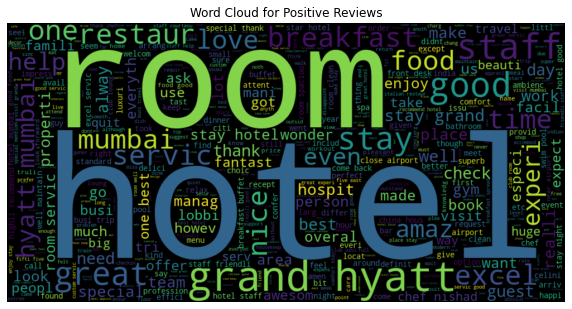

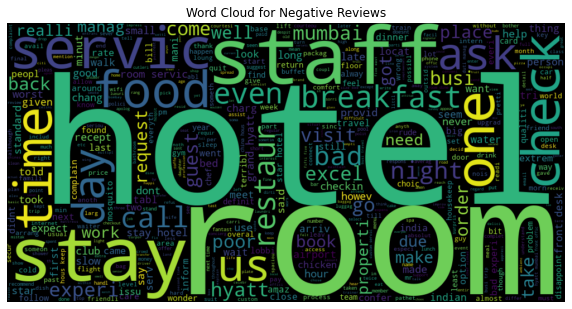

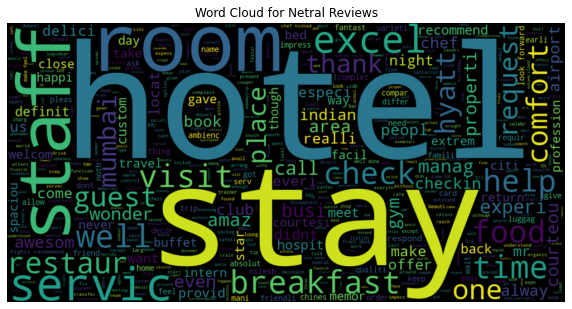

In [18]:
def generate_wordcloud_tb(df, sentiment_label):
    plt.figure(figsize=(10, 10))

    sentiment_text = df.loc[df['Textblob_Label'] == sentiment_label, 'Review']
    sentiment_text = sentiment_text.str.cat(sep=' ')

    wc = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
    wordcloud = wc.generate(sentiment_text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_label} Reviews')
    plt.axis('off')
    plt.show()

generate_wordcloud_tb(df, 'Positive')
generate_wordcloud_tb(df, 'Negative')
generate_wordcloud_tb(df, 'Netral')

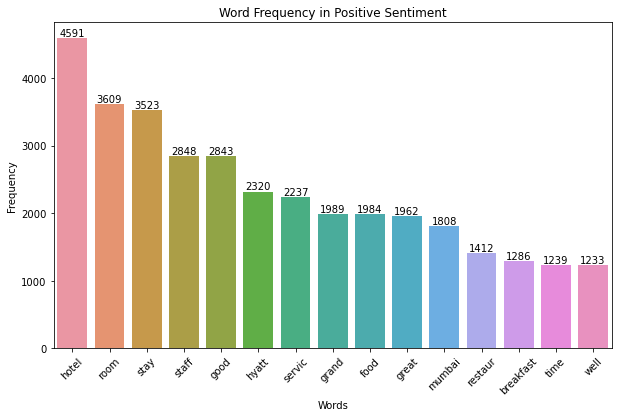

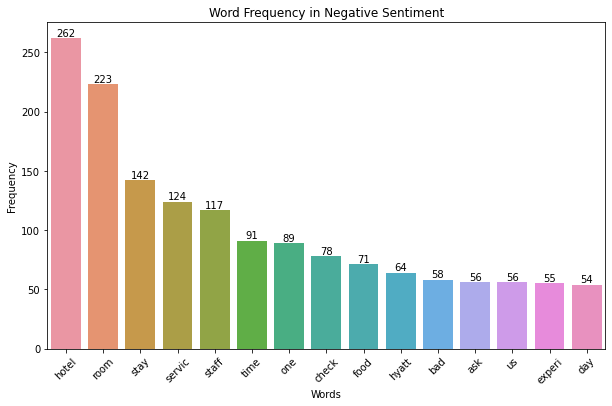

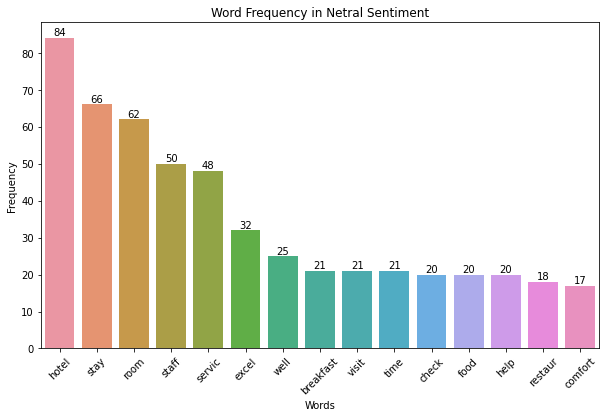

In [42]:
from nltk.probability import FreqDist
def get_word_frequency(tokens):
    freq_dist = FreqDist(tokens)
    return freq_dist

def get_top_words(tokens, n=15):
    freq_dist = FreqDist(tokens)
    top_words = freq_dist.most_common(n)
    return dict(top_words)

def plot_word_frequency(freq_dist, sentiment):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(freq_dist.keys()), y=list(freq_dist.values()))
    plt.title(f'Word Frequency in {sentiment} Sentiment')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

    for i, v in enumerate(top_words.values()):
        plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

    plt.show()


for sentiment_category in df['Textblob_Label'].unique():
    sentiment_data = df[df['Textblob_Label'] == sentiment_category]
    combined_tokens = []
    for text in sentiment_data['Review']:
        processed_tokens = tokenizing(text)
        # df['Review'].apply(tokenizing)
        combined_tokens.extend(processed_tokens)
        
    # freq_dist = get_word_frequency(combined_tokens)
    top_words = get_top_words(combined_tokens, n=15)
    plot_word_frequency(top_words, sentiment_category)

In [19]:
X = df['Review']
yTb = df["Textblob_Label"]

In [20]:
X_trainTb, X_testTb, y_trainTb, y_testTb = train_test_split(X, yTb, test_size=0.2, random_state=42)

In [21]:
vectorizer = CountVectorizer()
X_train_vectorizedTb = vectorizer.fit_transform(X_trainTb)
X_test_vectorizedTb = vectorizer.transform(X_testTb)
# print(X_train_vectorizedTb)

In [22]:
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='saga'),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC()
}

In [23]:
def plot_roc_curve(y_true, y_probs, model_name):
    n_classes = y_probs.shape[1] if len(y_probs.shape) > 1 else 1

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

In [24]:
def Compusion_Matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### Tanpa Sampling

Model: Naive Bayes
Accuracy: 0.923


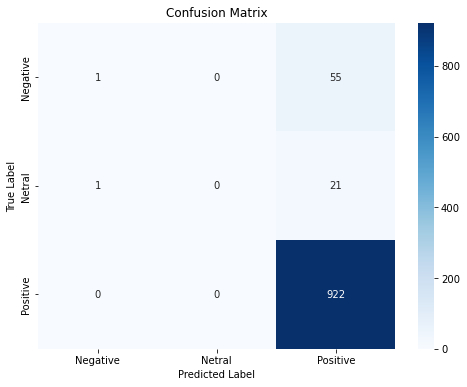

Model: Logistic Regression
Accuracy: 0.941


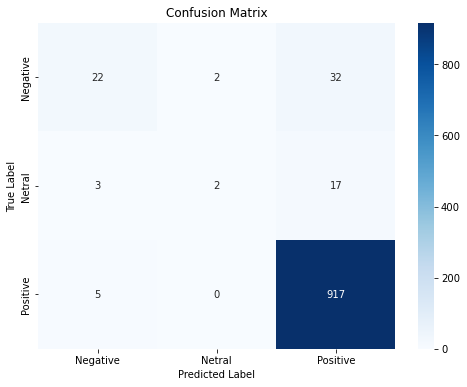

Model: Decision Tree
Accuracy: 0.922


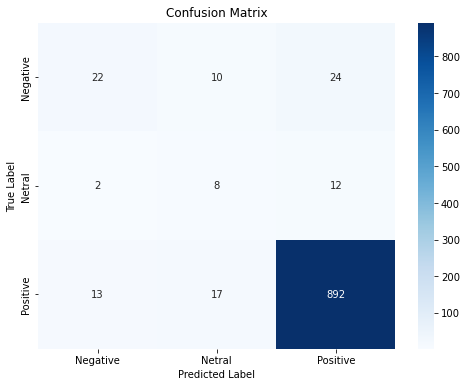

Model: Support Vector Machine
Accuracy: 0.922


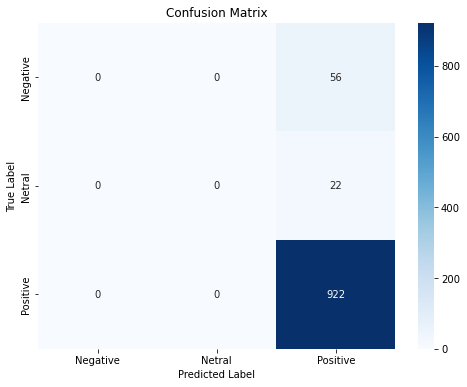

In [25]:
accuracies = []
model_names = []
for name, model in models.items():
    model.fit(X_train_vectorizedTb, y_trainTb)
    y_pred = model.predict(X_test_vectorizedTb)
    accuracy = accuracy_score(y_testTb, y_pred)

    accuracies.append(accuracy)
    model_names.append(name)

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    Compusion_Matrix(y_testTb, y_pred)

### SMOTE sampling

In [26]:
models2 = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='saga'),
    'Decission Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC()
}

Model: Naive Bayes
Accuracy: 0.932


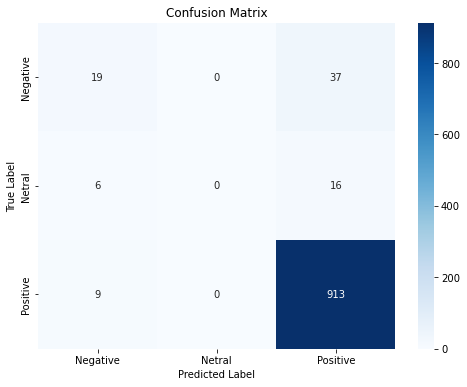

Model: Logistic Regression
Accuracy: 0.926


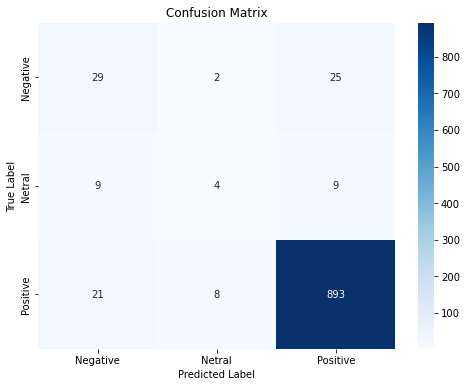

Model: Decission Tree
Accuracy: 0.872


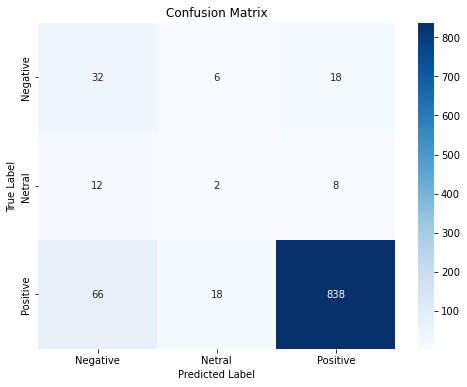

Model: Support Vector Machine
Accuracy: 0.928


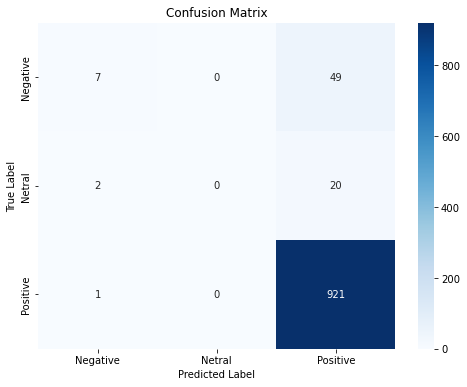

In [27]:
accuracies = []
model_names = []
for name, model in models2.items():
    sm = SMOTE(random_state=777)
    sm_xtrain_cv, sm_train_y = sm.fit_resample(X_train_vectorizedTb, y_trainTb)
    model.fit(sm_xtrain_cv, sm_train_y)
    y_pred = model.predict(X_test_vectorizedTb)
    accuracy = accuracy_score(y_testTb, y_pred)
    # report = classification_report(y_testTb, y_pred, zero_division=1)

    accuracies.append(accuracy)
    model_names.append(name)

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    # print(f'Classification Report:\n{report}\n')
    Compusion_Matrix(y_testTb, y_pred)

In [28]:
label_count_before = y_trainTb.value_counts()
label_count_after = pd.Series(sm_train_y).value_counts()

# Tampilkan jumlah setiap label
print("Jumlah setiap label sebelum sampling:")
print(label_count_before)

print("\nJumlah setiap label sesudah sampling:")
print(label_count_after)

Jumlah setiap label sebelum sampling:
Positive    3745
Negative     163
Netral        92
Name: Textblob_Label, dtype: int64

Jumlah setiap label sesudah sampling:
Positive    3745
Negative    3745
Netral      3745
Name: Textblob_Label, dtype: int64


## Analisis Sentimen berdasarkan Labelling Rating

In [29]:
df['Rating_Label'] = df['Rating'].apply(getRatingLabel)

In [30]:
df[['Rating','Review','Rating_Label']].head()

,Rating,Review,Rating_Label
0,5,visit grand hyatt occas sister birthday right ...,Positive
1,5,everyth fabul good hotel mumbai solo famili co...,Positive
2,5,fascin diet exercis knowledg sachin sir share ...,Positive
3,5,absolut love stay amaz food ambienc staff hosp...,Positive
4,4,book grand hyatt santacruz staycat friend birt...,Positive


In [31]:
df['Rating_Label'].value_counts()

Positive    4384
Negative     330
Netral       286
Name: Rating_Label, dtype: int64

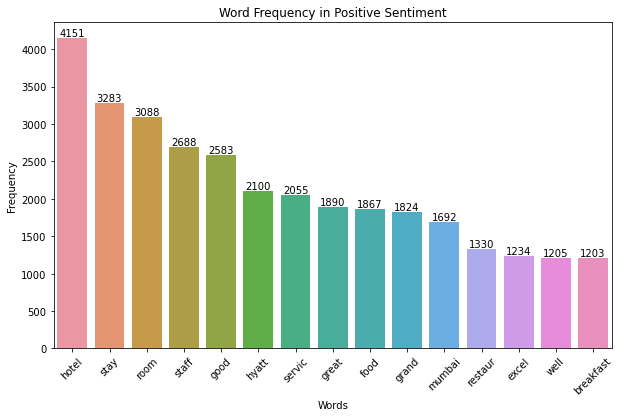

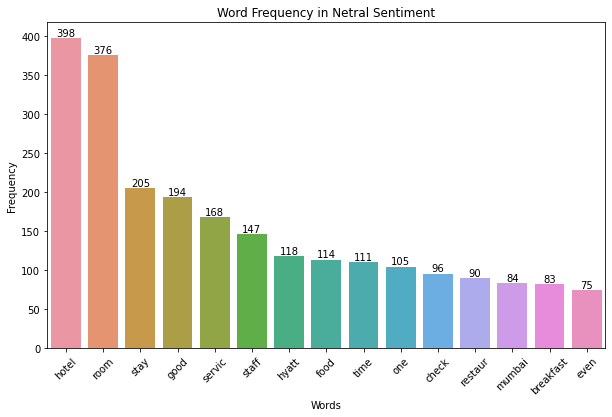

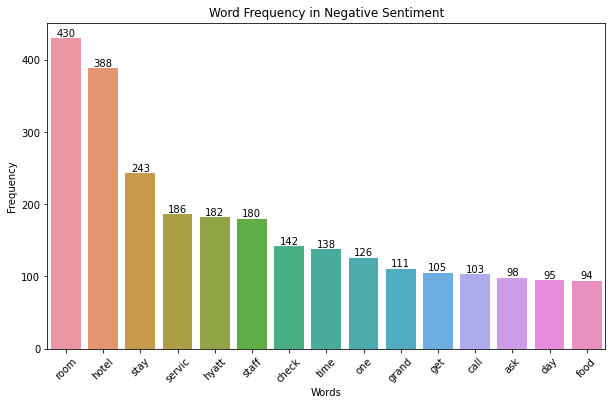

In [43]:
for sentiment_category in df['Rating_Label'].unique():
    sentiment_data = df[df['Rating_Label'] == sentiment_category]
    combined_tokens = []
    for text in sentiment_data['Review']:
        processed_tokens = tokenizing(text)
        # df['Review'].apply(tokenizing)
        combined_tokens.extend(processed_tokens)
        
    # freq_dist = get_word_frequency(combined_tokens)
    top_words = get_top_words(combined_tokens, n=15)
    plot_word_frequency(top_words, sentiment_category)

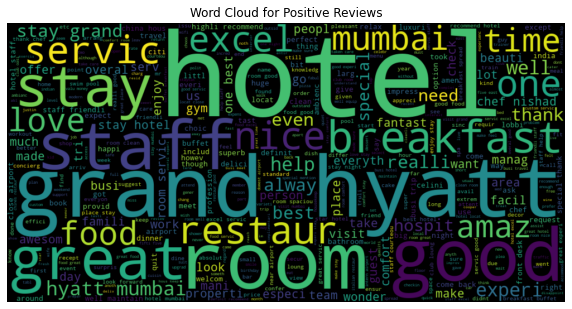

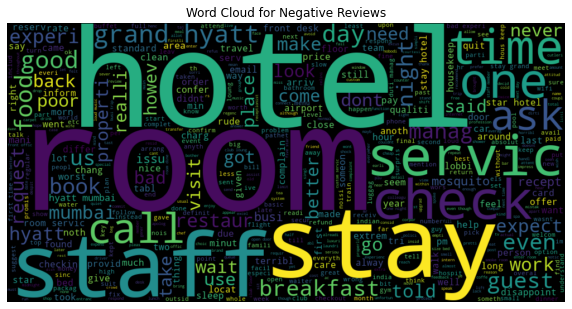

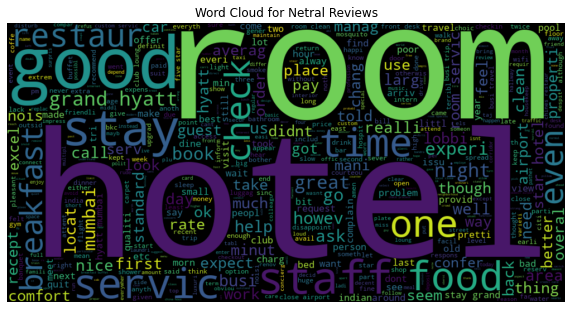

In [33]:
def generate_wordcloud_rating(df, sentiment_label):
    plt.figure(figsize=(10, 10))

    sentiment_text = df.loc[df['Rating_Label'] == sentiment_label, 'Review']
    sentiment_text = sentiment_text.str.cat(sep=' ')

    wc = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
    wordcloud = wc.generate(sentiment_text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_label} Reviews')
    plt.axis('off')
    plt.show()

generate_wordcloud_rating(df, 'Positive')
generate_wordcloud_rating(df, 'Negative')
generate_wordcloud_rating(df, 'Netral')

In [ ]:

for sentiment_category in df['Textblob_Label'].unique():
    sentiment_data = df[df['Textblob_Label'] == sentiment_category]
    combined_tokens = []
    for text in sentiment_data['Review']:
        processed_tokens = tokenizing(text)
        # df['Review'].apply(tokenizing)
        combined_tokens.extend(processed_tokens)
        
    # freq_dist = get_word_frequency(combined_tokens)
    top_words = get_top_words(combined_tokens, n=15)
    plot_word_frequency(top_words, sentiment_category)

In [34]:
X = df['Review']
yR = df["Rating_Label"]

In [35]:
XR_train, XR_test, yR_train, yR_test = train_test_split(X, yR, test_size=0.2, random_state=42)

In [36]:
XR_train_vectorized = vectorizer.fit_transform(XR_train)
XR_test_vectorized = vectorizer.transform(XR_test)

In [37]:
models2 = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='saga'),
    'Decission Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC()
}

### Tanpa Sampling

Model: Naive Bayes
Accuracy: 0.901


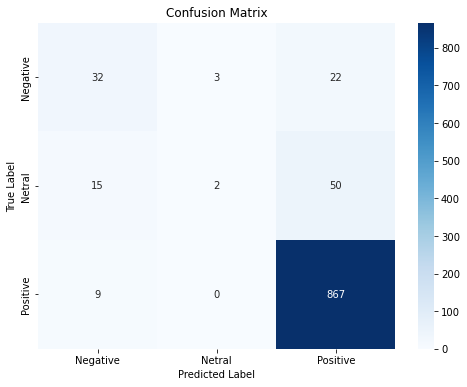

Model: Logistic Regression
Accuracy: 0.898


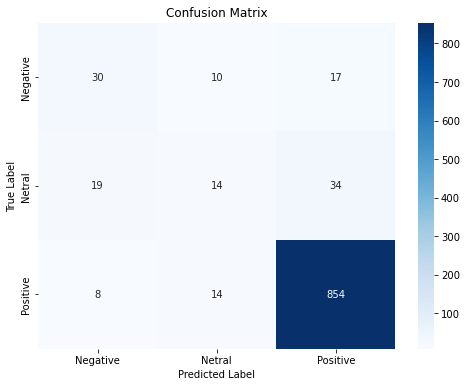

Model: Decission Tree
Accuracy: 0.863


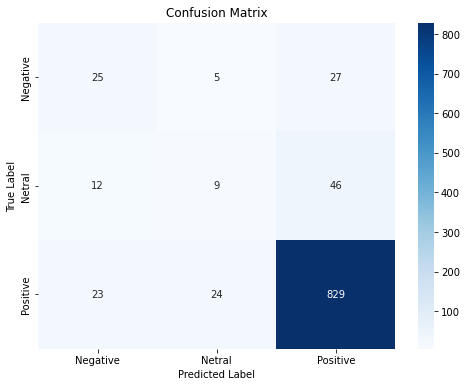

Model: Support Vector Machine
Accuracy: 0.888


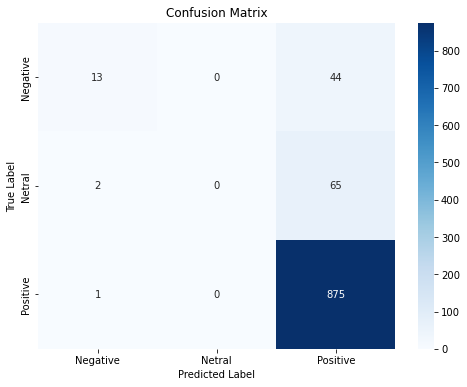

In [38]:
accuracies = []
model_names = []
for name, model in models2.items():
    model.fit(XR_train_vectorized, yR_train)
    yR_pred = model.predict(XR_test_vectorized)
    accuracy = accuracy_score(yR_test, yR_pred)
    # report = classification_report(yR_test, yR_pred, zero_division=1)

    accuracies.append(accuracy)
    model_names.append(name)

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    # print(f'Classification Report:\n{report}\n')
    Compusion_Matrix(yR_test, yR_pred)

### SMOTE Sampling

In [39]:
models2 = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='saga'),
    'Decission Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC()
}

Model: Naive Bayes
Accuracy: 0.895


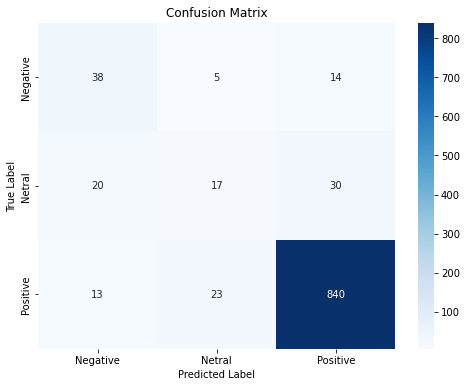

Model: Logistic Regression
Accuracy: 0.866


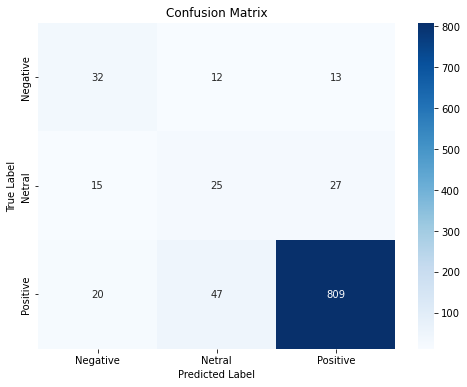

Model: Decission Tree
Accuracy: 0.775


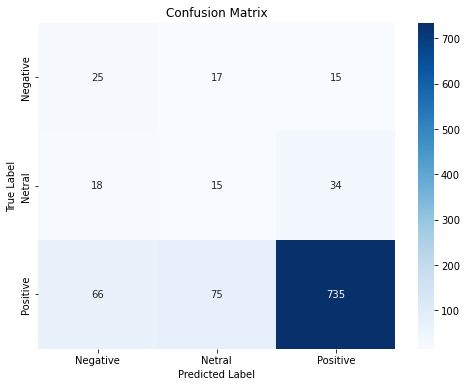

Model: Support Vector Machine
Accuracy: 0.869


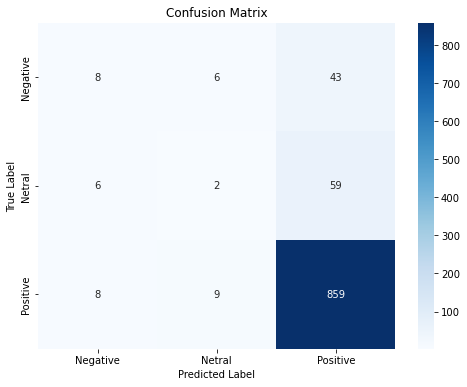

In [40]:
accuracies = []
model_names = []
for name, model in models2.items():
    sm = SMOTE(random_state=777)
    sm_xtrain_cv, sm_train_y = sm.fit_resample(XR_train_vectorized, yR_train)
    model.fit(sm_xtrain_cv, sm_train_y)
    yR_pred = model.predict(XR_test_vectorized)
    accuracy = accuracy_score(yR_test, yR_pred)
    # report = classification_report(y_testTb, y_pred, zero_division=1)

    accuracies.append(accuracy)
    model_names.append(name)

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    # print(f'Classification Report:\n{report}\n')
    Compusion_Matrix(yR_test, yR_pred)

In [41]:
label_count_before = yR_train.value_counts()
label_count_after = pd.Series(sm_train_y).value_counts()

# Tampilkan jumlah setiap label
print("Jumlah setiap label sebelum sampling:")
print(label_count_before)

print("\nJumlah setiap label sesudah sampling:")
print(label_count_after)

Jumlah setiap label sebelum sampling:
Positive    3508
Negative     273
Netral       219
Name: Rating_Label, dtype: int64

Jumlah setiap label sesudah sampling:
Positive    3508
Netral      3508
Negative    3508
Name: Rating_Label, dtype: int64
